# Practical Assignment 2

In this assignment an MLP is trained on the MNIST dataset. The MNIST dataset (provided by Yann Lecun) consists of handwritten digits of which an example is shown in figure 1. 

The MLP (multi layer perceptron) is trained for 20 epochs with a batch size of 32. The network consists of 1 hidden layer with 10 units. 

![687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067.jpeg](attachment:687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067.jpeg)

Figure 1

#### Imports

In [24]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from utils import RandomIterator, get_mnist #as provided in the course
import matplotlib.pyplot as plt
import matplotlib

#### Visualization function

In [25]:
def visualizeLoss(ep_loss, test_loss):
    matplotlib.style.use('ggplot')
    figure = plt.figure(figsize=(15,8))
    ax = figure.add_subplot(111)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    xticks = np.arange(1, 21, 5)
    ax.set_xticks(xticks)  
    e_train, l_train = [point['epoch'] for point in ep_loss], [point['loss'] for point in ep_loss]
    e_test, l_test = [point['epoch'] for point in test_loss], [point['loss'] for point in test_loss]
    train, = plt.plot(e_train, l_train, 'b', label = 'train loss')
    test, = plt.plot(e_test, l_test, 'r', label = 'test loss')
    plt.legend([train, test], ['train loss', 'test loss'])
    plt.show() 

### Part 1 - training of 3 different neural networks

####  Defining the network
In the class below the structure of the MLP is defined. The MLP is the 2 layer network.


In [26]:
class MLP(Chain):
    """
    
    Implementation of a 2-layer Fully Connected network 
    
    """
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) # Input layer n_units -> n_units
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(n_units, n_out)
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        output = self.l3(h2)
        return output
    
class SingleLayer(Chain):
    """
    Implementation of a 1-layer Fully Connected network
    """
    def __init__(self, n_units, n_out):
        super(SingleLayer, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) # Input layer n_units -> n_units
            self.l2 = L.Linear(n_units, n_out)
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        output = self.l2(h1)
        return output
    
class ThreeLayers(Chain):
    """
    
    Implementation of a 3-layer Fully Connected network 
    
    """
    def __init__(self, n_units, n_out):
        super(ThreeLayers, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) # Input layer n_units -> n_units
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_units)
            self.l4 = L.Linear(n_units, n_out)
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        output = self.l4(h3)
        return output
  
class Classifier(Chain):
    """
    Classifier chain on top of Neural Network chain 
    for accuracy evaluation and prediction
    
    """
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({'loss': loss, 'accuracy': accuracy}, self)
        return loss


#### Training and test set creation

In [27]:
# Retrieve train & test data      
train, test, dimension = get_mnist(n_dim=1)
# split test inputs and labels
inputs, labels = np.array([tup[0] for tup in test]), np.array([tup[1] for tup in test])

# Set up 1 layer model
model_sl = SingleLayer(10,10)
classifier_sl = Classifier(model_sl)
optimizer_sl = optimizers.SGD()
optimizer_sl.setup(classifier_sl)

#Set up 2 layer model
model_mlp = MLP(10, 10)
classifier_mlp = Classifier(model_mlp)
optimizer_mlp = optimizers.SGD()
optimizer_mlp.setup(classifier_mlp)

#Set up 3 layer model
model_tl = ThreeLayers(10, 10)
classifier_tl = Classifier(model_tl)
optimizer_tl = optimizers.SGD()
optimizer_tl.setup(classifier_tl)

1


#### Implement the training & test loop


In [28]:
def training(train, test, inputs, labels, classifier, optimizer, nr_of_epochs):
    iterator = RandomIterator(train,32)

    av_loss = []
    ep_loss = []
    test_loss = []
    for epoch in range(1,nr_of_epochs):
         for batch in iterator:
            sources,targets = batch[0], batch[1]
            classifier.cleargrads()
            loss = F.sum(classifier(sources, targets))
            loss.backward()
            av_loss.append(loss.data)    
            optimizer.update()
         loss =  sum(av_loss) / len(av_loss)
         print({'epoch': epoch, 'train_loss': loss})
         ep_loss.append({'epoch': epoch, 'loss': loss})
         # test classifier
         loss = F.sum(classifier(inputs, labels))
         print({'epoch': epoch, 'test_loss': float(loss.data)})
         test_loss.append({'epoch': epoch, 'loss': loss.data})
         av_loss = []
    return ep_loss, test_loss

#### Training for 1 layer neural network

{'epoch': 1, 'train_loss': 2.2664307778881443}
{'epoch': 1, 'test_loss': 2.2199249267578125}
{'epoch': 2, 'train_loss': 2.18718215727037}
{'epoch': 2, 'test_loss': 2.1549770832061768}
{'epoch': 3, 'train_loss': 2.113812704240122}
{'epoch': 3, 'test_loss': 2.089515209197998}
{'epoch': 4, 'train_loss': 2.0333774089813232}
{'epoch': 4, 'test_loss': 2.021193742752075}
{'epoch': 5, 'train_loss': 1.9472683514318159}
{'epoch': 5, 'test_loss': 1.940413475036621}
{'epoch': 6, 'train_loss': 1.8410361466869232}
{'epoch': 6, 'test_loss': 1.8527615070343018}
{'epoch': 7, 'train_loss': 1.7316775783415763}
{'epoch': 7, 'test_loss': 1.7623323202133179}
{'epoch': 8, 'train_loss': 1.6203605474964264}
{'epoch': 8, 'test_loss': 1.6695367097854614}
{'epoch': 9, 'train_loss': 1.5074621400525492}
{'epoch': 9, 'test_loss': 1.5795788764953613}
{'epoch': 10, 'train_loss': 1.401419339641448}
{'epoch': 10, 'test_loss': 1.4911158084869385}
{'epoch': 11, 'train_loss': 1.301281044560094}
{'epoch': 11, 'test_loss': 1

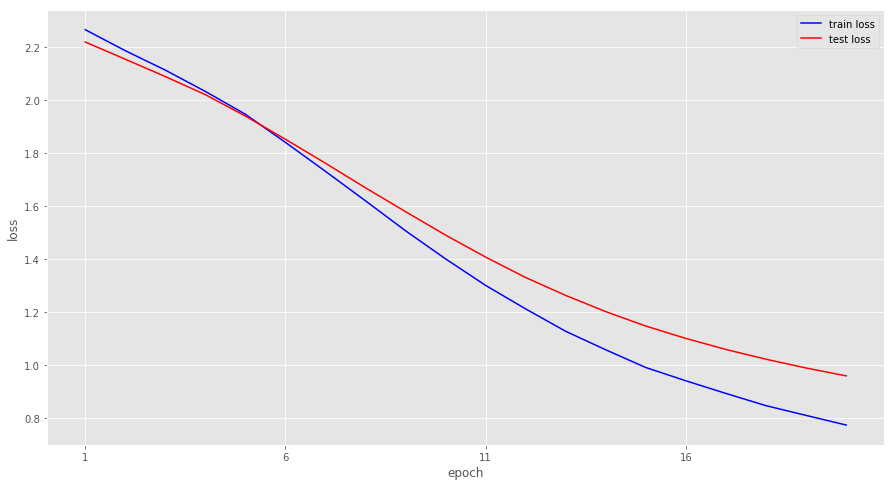

In [29]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_sl, optimizer_sl, 21)
visualizeLoss(ep_loss, test_loss)

#### Training 2 layer neural network

{'epoch': 1, 'train_loss': 2.2941607198407574}
{'epoch': 1, 'test_loss': 2.2578012943267822}
{'epoch': 2, 'train_loss': 2.2355843128696566}
{'epoch': 2, 'test_loss': 2.20908260345459}
{'epoch': 3, 'train_loss': 2.1799198581326391}
{'epoch': 3, 'test_loss': 2.159867763519287}
{'epoch': 4, 'train_loss': 2.1245926810849096}
{'epoch': 4, 'test_loss': 2.1127216815948486}
{'epoch': 5, 'train_loss': 2.0618517091197353}
{'epoch': 5, 'test_loss': 2.0557451248168945}
{'epoch': 6, 'train_loss': 1.9892065255872664}
{'epoch': 6, 'test_loss': 1.991770625114441}
{'epoch': 7, 'train_loss': 1.9144701688520369}
{'epoch': 7, 'test_loss': 1.9290846586227417}
{'epoch': 8, 'train_loss': 1.8385377122509865}
{'epoch': 8, 'test_loss': 1.861453652381897}
{'epoch': 9, 'train_loss': 1.7587986799978441}
{'epoch': 9, 'test_loss': 1.791428565979004}
{'epoch': 10, 'train_loss': 1.6713210959588327}
{'epoch': 10, 'test_loss': 1.7165170907974243}
{'epoch': 11, 'train_loss': 1.5850367469172324}
{'epoch': 11, 'test_loss':

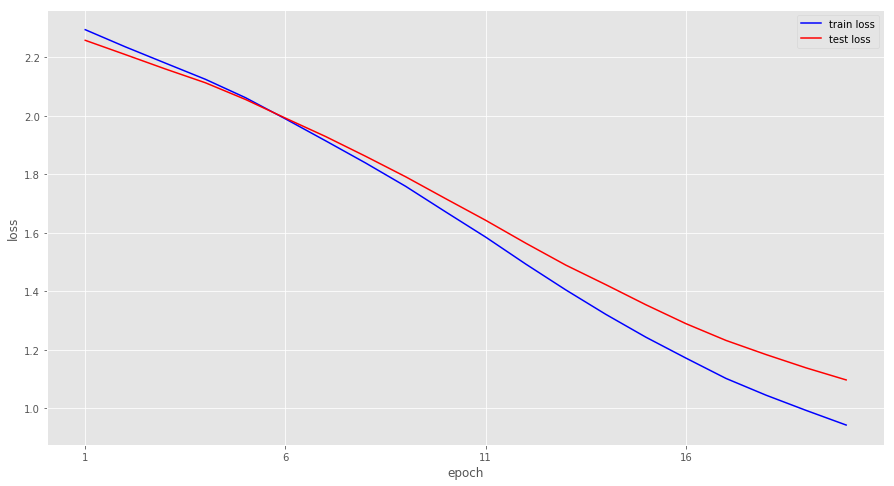

In [30]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_mlp, optimizer_mlp, 21)
visualizeLoss(ep_loss, test_loss)

#### Training 3 layer neural network

{'epoch': 1, 'train_loss': 2.3052643883612847}
{'epoch': 1, 'test_loss': 2.2993228435516357}
{'epoch': 2, 'train_loss': 2.2961142293868528}
{'epoch': 2, 'test_loss': 2.2939703464508057}
{'epoch': 3, 'train_loss': 2.288194587153773}
{'epoch': 3, 'test_loss': 2.2876334190368652}
{'epoch': 4, 'train_loss': 2.2782566009029264}
{'epoch': 4, 'test_loss': 2.2789905071258545}
{'epoch': 5, 'train_loss': 2.2662462111442321}
{'epoch': 5, 'test_loss': 2.268404960632324}
{'epoch': 6, 'train_loss': 2.2509053599449897}
{'epoch': 6, 'test_loss': 2.2559702396392822}
{'epoch': 7, 'train_loss': 2.2341377658228718}
{'epoch': 7, 'test_loss': 2.2410085201263428}
{'epoch': 8, 'train_loss': 2.2113630617818525}
{'epoch': 8, 'test_loss': 2.2213194370269775}
{'epoch': 9, 'train_loss': 2.1845023016775809}
{'epoch': 9, 'test_loss': 2.199178457260132}
{'epoch': 10, 'train_loss': 2.1527295035700642}
{'epoch': 10, 'test_loss': 2.1725728511810303}
{'epoch': 11, 'train_loss': 2.1171330021273707}
{'epoch': 11, 'test_los

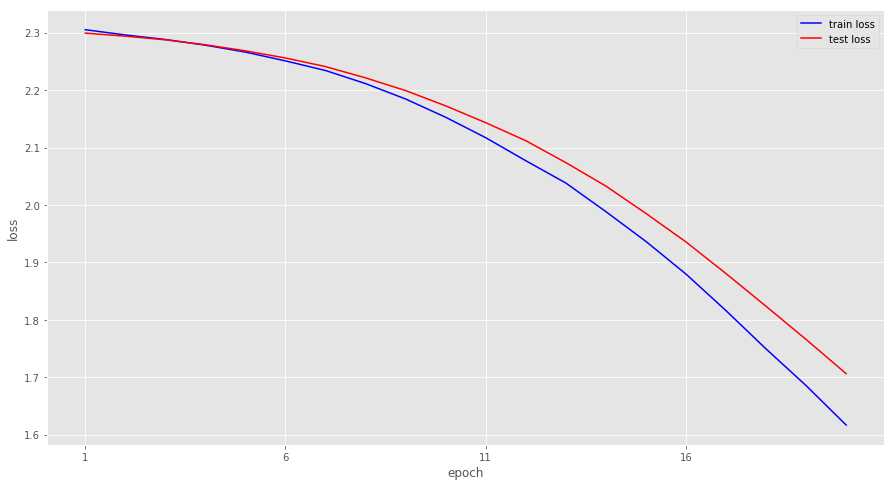

In [31]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_tl, optimizer_tl, 21)
visualizeLoss(ep_loss, test_loss)

#### Conclusions part 1

In [32]:
#TODO

### Part 2 - Convolutional Neural Network

Implementation of a convolutional neural network consisting of 1 convolutional layer, 1 max pooling layer and 1 fully connected layer. 

Convolutional layer has 5 outputs, kernel size of 5, stride of 1 and padding of 0

In [33]:
class ConvNet(Chain):
    """
    
    Implementation of a Convolutional Network 
    
    """
    def __init__(self):
        super(ConvNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=None, out_channels=5, ksize=5, stride=1, pad=0)
            self.l1 = L.Linear(None, 10)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2)
        output = F.softmax(self.l1(h))
        return output
    

#### Model creation

In [34]:
model_conv = ConvNet()
classifier_conv = Classifier(model_conv)
optimizer_conv = optimizers.Adam()
optimizer_conv.setup(classifier_conv)

#### Model training

In [35]:
train, test, dimension = get_mnist(n_dim=3)
inputs, labels = np.array([tup[0] for tup in test]), np.array([tup[1] for tup in test])


3


In [ ]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_conv, optimizer_conv, 21)
visualizeLoss(ep_loss, test_loss)

{'epoch': 1, 'train_loss': 2.2544217878772366}
{'epoch': 1, 'test_loss': 2.1954092979431152}
{'epoch': 2, 'train_loss': 2.0006481370618268}
{'epoch': 2, 'test_loss': 1.9334605932235718}
{'epoch': 3, 'train_loss': 1.7624091832868514}
{'epoch': 3, 'test_loss': 1.7965501546859741}
{'epoch': 4, 'train_loss': 1.6728401145627421}
{'epoch': 4, 'test_loss': 1.741385817527771}
{'epoch': 5, 'train_loss': 1.6382134076087707}
{'epoch': 5, 'test_loss': 1.7019109725952148}
{'epoch': 6, 'train_loss': 1.6087219676663798}
{'epoch': 6, 'test_loss': 1.6772767305374146}
{'epoch': 7, 'train_loss': 1.5887779112785094}
{'epoch': 7, 'test_loss': 1.6582019329071045}
{'epoch': 8, 'train_loss': 1.5759915190358316}
{'epoch': 8, 'test_loss': 1.6426228284835815}
{'epoch': 9, 'train_loss': 1.5651281149156633}
{'epoch': 9, 'test_loss': 1.635401964187622}
{'epoch': 10, 'train_loss': 1.5564221682087067}
{'epoch': 10, 'test_loss': 1.632300615310669}
{'epoch': 11, 'train_loss': 1.5507467292970227}
{'epoch': 11, 'test_los

### Part 3 Explain in which ways convolution is biologically plausible and biologically implausible

In [20]:
#TODO

### Part 4 Model changes

In [21]:
class ConvNetImproved(Chain):
    """
    
    Implementation of a Convolutional Network 
    
    """
    def __init__(self):
        super(ConvNetImproved, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=None, out_channels=5, ksize=5, stride=1, pad=0)
            self.conv2 = L.Convolution2D(in_channels=5, out_channels=16, ksize=5, stride=1, pad=0)
            self.l1 = L.Linear(None, 200)
            self.l2 = L.Linear(200, 10)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2)
        h = F.dropout(F.relu(self.l1(h)))
        output = F.softmax(self.l2(h))
        return output

In [22]:
model_conv2 = ConvNetImproved()
classifier_conv2 = Classifier(model_conv2)
optimizer_conv2 = optimizers.Adam()
optimizer_conv2.setup(classifier_conv2)

{'epoch': 1, 'train_loss': 2.2276410056698706}
{'epoch': 1, 'test_loss': 2.0982301235198975}
{'epoch': 2, 'train_loss': 1.9346426571569135}
{'epoch': 2, 'test_loss': 1.880002498626709}
{'epoch': 3, 'train_loss': 1.7794995384831582}
{'epoch': 3, 'test_loss': 1.7879756689071655}
{'epoch': 4, 'train_loss': 1.707817477564658}
{'epoch': 4, 'test_loss': 1.7281420230865479}
{'epoch': 5, 'train_loss': 1.6531528272936422}
{'epoch': 5, 'test_loss': 1.6976369619369507}
{'epoch': 6, 'train_loss': 1.6140508421005741}
{'epoch': 6, 'test_loss': 1.6743789911270142}
{'epoch': 7, 'train_loss': 1.5830980731594948}
{'epoch': 7, 'test_loss': 1.6565982103347778}
{'epoch': 8, 'train_loss': 1.5739729096812587}
{'epoch': 8, 'test_loss': 1.6449472904205322}
{'epoch': 9, 'train_loss': 1.5769185673805974}
{'epoch': 9, 'test_loss': 1.6247103214263916}
{'epoch': 10, 'train_loss': 1.5541053971936625}
{'epoch': 10, 'test_loss': 1.6167559623718262}
{'epoch': 11, 'train_loss': 1.5484589184484174}
{'epoch': 11, 'test_lo

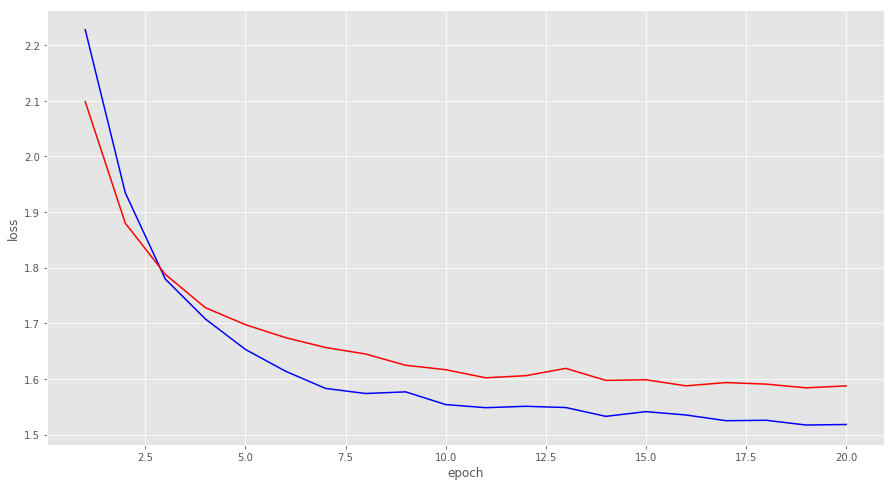

In [23]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_conv2, optimizer_conv2, 21)
visualizeLoss(ep_loss, test_loss)